In [1]:
import torch
import torch.nn as nn
import torchvision #파이토치 이미지 처리 사용 패키지
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# GPU 있을때 예시
# X = np.randn(3, 2)
# X.to(device) : GPU로 보내는 함수

In [4]:
input_size = 784 # 이미자 28x28 -> 784 
hidden_size = 500
num_classes = 10 #  0~9까지 숫자 10개
num_epochs = 10 # 몇번 학습할 것인지
batch_size = 32 # 전체 학습데이터를 쪼개서 학습
learning_rate = 0.001 # gradient decsent 연산할 때 이동 step size

In [10]:
train_dataset = torchvision.datasets.MNIST(root='./MNIST/processed/',
                                          train = True,
                                          transform = transforms.ToTensor(),
                                          download=True)

100.0%


Extracting ./MNIST/processed/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST/processed/MNIST\raw


102.8%


Extracting ./MNIST/processed/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST/processed/MNIST\raw


100.0%


Extracting ./MNIST/processed/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST/processed/MNIST\raw


112.7%
C:\Users\lhj90\anaconda3\envs\mlpractice\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./MNIST/processed/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST/processed/MNIST\raw
Processing...
Done!


In [13]:
len(train_dataset)

60000

In [11]:
test_dataset = torchvision.datasets.MNIST(root='./MNIST/processed/',
                                          train = False,
                                          transform = transforms.ToTensor(),
                                          download=True)

In [14]:
len(test_dataset)

10000

In [ ]:
'''
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
'''

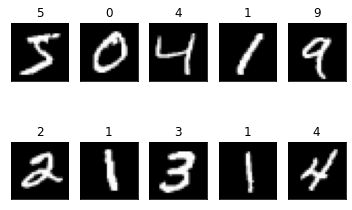

In [15]:
fig = plt.figure()
 
for i in range(10):
    # 2x5 그리드에 i+1번째 subplot을 추가하고 얻어옴
    subplot = fig.add_subplot(2, 5, i + 1)

    # x, y 축의 지점 표시를 안함
    subplot.set_xticks([])
    subplot.set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    subplot.set_title('%d' % train_dataset[i][1])

    # 입력으로 사용한 i번째 테스트 이미지를 28x28로 재배열하고
    # 이 2차원 배열을 그레이스케일 이미지로 출력
    subplot.imshow(train_dataset[i][0].squeeze().numpy(), cmap='gray')

plt.show()

In [16]:
# Data loader: batch단위로 model에 데이터를 공급해줘

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True) #shuffle 데이터를 섞어줘

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) #inputsize : 784 (28*28의 선형화) # hidden = 500 (자기맘대로 지정..)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))  # 784 -> 500
        out = self.relu(self.fc2(out)) # 여기까지가 feature extractor  500 -> 500
        out = self.fc3(out) #0~9 10dim #여기서 classification
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [18]:
model

NeuralNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)

In [19]:
criterion = nn.CrossEntropyLoss() #softmax가 들어있음
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [20]:
# Train the model
for epoch in range(num_epochs):
    train_loss = []
    model.train()
    for i, (images, labels) in enumerate(train_loader): # i : step  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
       
        loss.backward()
       
        optimizer.step()
        train_loss.append(loss.item())
    
    print ('Epoch [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, sum(train_loss)/len(train_loss)))
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images) # [batch, 10(확률값 어떤것이 가장 큰 확률을 가지냐)]
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Epoch [1/10], Loss: 2.2587
Accuracy of the network on the test images: 46.12 %
Epoch [2/10], Loss: 2.0826
Accuracy of the network on the test images: 63.82 %
Epoch [3/10], Loss: 1.6384
Accuracy of the network on the test images: 73.93 %
Epoch [4/10], Loss: 1.0828
Accuracy of the network on the test images: 80.94 %
Epoch [5/10], Loss: 0.7709
Accuracy of the network on the test images: 83.98 %
Epoch [6/10], Loss: 0.6198
Accuracy of the network on the test images: 85.98 %
Epoch [7/10], Loss: 0.5354
Accuracy of the network on the test images: 87.3 %
Epoch [8/10], Loss: 0.4820
Accuracy of the network on the test images: 88.16 %
Epoch [9/10], Loss: 0.4453
Accuracy of the network on the test images: 88.69 %
Epoch [10/10], Loss: 0.4184
Accuracy of the network on the test images: 89.19 %


In [21]:
#어떤 이미지를 못맞췄는지
bad_prediction = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                bad_prediction.append([images[i].detach().cpu().numpy(), predicted[i].detach().cpu(), labels[i].detach().cpu()])

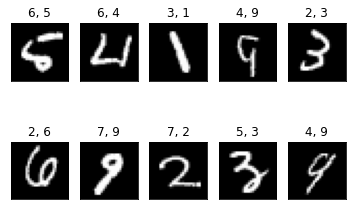

In [22]:
fig = plt.figure()
 
for i in range(10):
    # 2x5 그리드에 i+1번째 subplot을 추가하고 얻어옴
    subplot = fig.add_subplot(2, 5, i + 1)

    # x, y 축의 지점 표시를 안함
    subplot.set_xticks([])
    subplot.set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    subplot.set_title(f'{bad_prediction[i][1]}, {bad_prediction[i][2]}')

    # 입력으로 사용한 i번째 테스트 이미지를 28x28로 재배열하고
    # 이 2차원 배열을 그레이스케일 이미지로 출력
    subplot.imshow(bad_prediction[i][0].reshape(28, 28), cmap='gray')

plt.show()